# Map extraction - Example with two maps
This notebook provides an overview of the work done on maps in order to obtain the whole processed dataset announced in milestone 1. It shows how we extract polygons from raw maps (gifs or pdf). This process has been automated with a script for all the directories.

In [1]:
from pylab import contour
import matplotlib.pyplot as plt
from PIL import ImageFilter, Image, ImageDraw
from datetime import date, timedelta
import numpy as np
from PIL import Image
import cv2
from skimage import measure
import os
import pandas as pd
from scipy.spatial import distance
import json
import visvalingamwyatt as vw
import folium

%matplotlib inline

First, we define the colors and the arrays of colors we will need.

In [2]:
black = np.array([0, 0, 0])
white = np.array([255, 255, 255])

green = np.array([204, 255, 102])
yellow = np.array([255, 255, 0])
orange = np.array([255, 153, 0])
red = np.array([255, 0, 0])

danger_colors_code = ['#ccff66', '#ffff00', '#ff9900', '#ff0000']

shades_danger = [green, yellow, orange, red]

danger_image_shades = [green, yellow, orange, red, white]

light_blue = np.array([213, 252, 252])
light_medium_blue = np.array([168, 217, 241])
medium_blue = np.array([121, 161, 229])
dark_medium_blue = np.array([68, 89, 215])
dark_blue = np.array([47, 36, 162])
purple = np.array([91, 32, 196])

snow_color_code = ['#d5fcfc', '#a8d9f1', '#79a1e5', '#4459d7', '#2f24a2', '#5b20c4']

shades_snow = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple]

shades_grey = [np.array([c,c,c]) for c in range(255)]

snow_image_shades = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple, white]

raw_red = np.array([255, 0, 0])
raw_green = np.array([0, 255, 0])
raw_blue = np.array([0, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_cyan = np.array([0, 255, 255])
raw_yellow = np.array([255, 255, 0])

The defined functions below will be using those set of colors.

In [4]:
SMOOTHING_THRESHOLD = 0.0001

def keep_colors(img, colors, replace_with=white):
    """return a new image with only the `colors` selected, other pixel are `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

def remove_colors(img, colors, replace_with=white):
    """return a new image without the `colors` selected which will be replaced by `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[keep] = replace_with
    return new_img

def replace_color(img, color_map):
    """return a new image replacing the image colors which will be mapped to their corresponding colors in `color_map` (df)"""
    new_img = img.copy()
    for _, (source, target) in color_map.iterrows():
        new_img[(img == source).all(axis=-1)] = target
    return new_img

def build_color_map(img_arr, image_shades):
    """return colormap as dataframe"""
    im_df = pd.DataFrame([img_arr[i,j,:] for i,j in np.ndindex(img_arr.shape[0],img_arr.shape[1])])
    im_df = im_df.drop_duplicates()
    image_colors = im_df.as_matrix()
    
    colors = np.zeros(image_colors.shape)
    dist = distance.cdist(image_colors, image_shades, 'sqeuclidean')

    for j in range(dist.shape[0]):
        distances = dist[j,:]
        colors[j, :] = image_shades[distances.argmin()]
        
    color_map = pd.DataFrame(
        {'source': image_colors.tolist(),
         'target': colors.tolist()
        })
    
    return color_map

Here are the two images we will process.

In [13]:
danger_path = '../data/slf/2001/nbk/de/gif/20001230_nbk_de_c.gif'
snow_path = '../data/slf/2010/hstop/en/gif/20100103_hstop_en_c.gif'

danger_img = Image.open(danger_path)
danger_img = danger_img.convert('RGB')
danger_img_arr = np.array(danger_img)

snow_img = Image.open(snow_path)
snow_img = snow_img.convert('RGB')
snow_img_arr = np.array(snow_img)

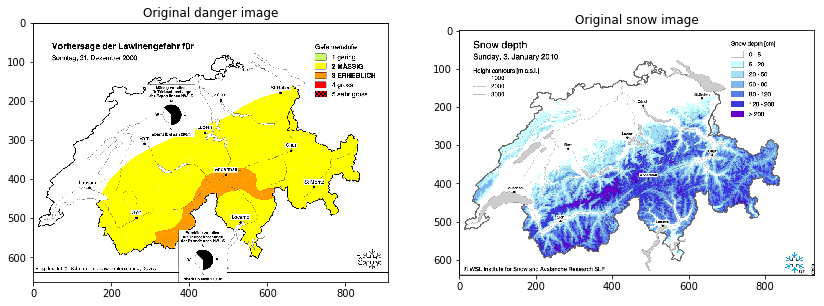

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))

# original danger image
axes[0].imshow(danger_img_arr);
axes[0].set_title('Original danger image');

# original snow image
axes[1].imshow(snow_img_arr);
axes[1].set_title('Original snow image');

In [18]:
def numpify(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o


def coord_color(img, color):
    return np.array(list(zip(*(img == color).all(-1).nonzero())))

def open_mask(height, width):
    masks_path = '../map-masks/'
    mask_name = '{}x{}.gif'.format(height, width)
    mask_path = os.path.join(masks_path, mask_name)
    mask = Image.open(mask_path)
    mask = mask.convert('RGB')
    mask = np.array(mask)
    
    landmarks_pix = {
        geo_point: (width, height)
        for geo_point, color in landmarks_colors.items()
        for height, width in coord_color(mask, color)
    }
    
    binary_mask = (mask != 255).any(-1)  # different of white
    return binary_mask, landmarks_pix

# remove contours areas that have more than 30% of white
WHITE_RATIO_THRESHOLD = .3

def color_contours(img, color):
    img = numpify(img)
    color = numpify(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= WHITE_RATIO_THRESHOLD:
            filter_contours.append(c)
    return filter_contours
    

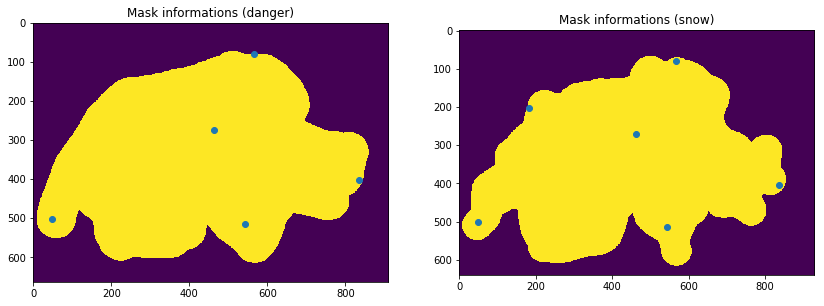

In [19]:
# load mask of this size
leman_west = (6.148131, 46.206042)
quatre_canton_north = (8.435177, 47.082150)
majeur_east = (8.856851, 46.151857)
east_end = (10.472221, 46.544303)
constance_nw = (9.035247, 47.812716)
jura = (6.879290, 47.352935)

landmarks_colors = {
    leman_west: raw_red,
    quatre_canton_north: raw_green,
    majeur_east: raw_blue,
    constance_nw: raw_pink,
    east_end: raw_yellow,
    jura: raw_cyan
}

d_binary_mask, d_landmarks_pix = open_mask(*danger_img_arr.shape[:2])
s_binary_mask, s_landmarks_pix = open_mask(*snow_img_arr.shape[:2])

#display binary masks
fig, axes = plt.subplots(1, 2, figsize=(14,10))

# mask corresponding to danger image
axes[0].imshow(d_binary_mask);
widths, heights = list(zip(*d_landmarks_pix.values()))
axes[0].scatter(widths, heights);
axes[0].set_title('Mask informations (danger)');

# mask corresponding to danger image
axes[1].imshow(s_binary_mask);
widths, heights = list(zip(*s_landmarks_pix.values()))
axes[1].scatter(widths, heights);
axes[1].set_title('Mask informations (snow)');